In [165]:
import torch
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, TensorDataset
from scipy.interpolate import griddata

from collections import OrderedDict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyDOE import lhs
from scipy.stats import uniform,norm

import os
import re

os.chdir("/home/s2113174/Projects-1")

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Making the data for an Inverse Problem following the parametric ODE

$$\frac{\partial^{2} u}{\partial t^{2}} = \frac{\partial^{2} u}{\partial x^{2}} $$
$$u(0,t) = u(1,t)=0$$
$$u(x,0) = sin(5\pi x) + 2sin(7 \pi x)$$
$$\frac{\partial u(x,0)}{\partial t} = 0$$

In [166]:
def exact_solution(x,t):
    u = np.sin(5*np.pi*x)*np.cos(5*np.pi*t) + 2*np.sin(7*np.pi*x)*np.cos(7*np.pi*t)
    return u      

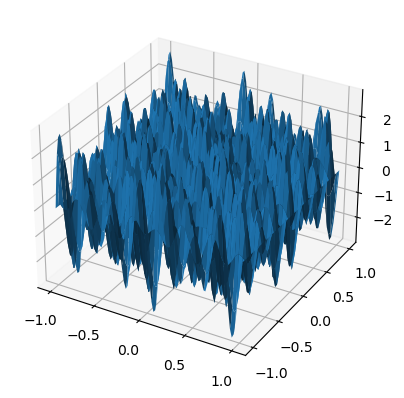

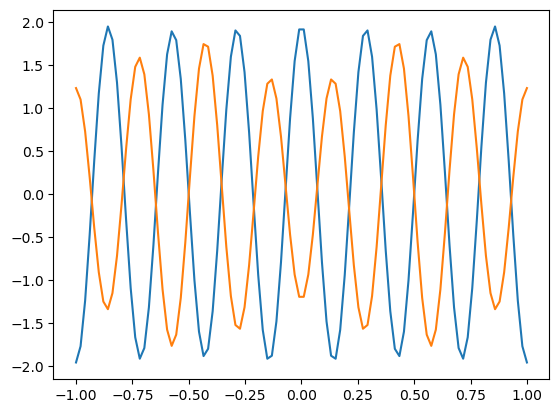

In [167]:
x = np.linspace(-1,1,100)
y = np.linspace(-1,1,100)

xx, yy = np.meshgrid(x, y)

z = exact_solution(xx,yy)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf=ax.plot_surface(xx,yy,z)
plt.show()

plt.plot(y,z[:,10])
plt.plot(y,z[:,90])
#h = plt.plot_surface(x, y, z)

#plt.axis('scaled')
#plt.colorbar()
#plt.show()

## Feed Forward Neural Network

In [168]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## Heat Equation definition for the NN

In [169]:
def DE(self,x,t,pr):
    """ The pytorch autograd version of calculating residual """
    u = self(torch.cat([x,t,pr], dim=1))
    
    u_x = torch.autograd.grad(
        u, x, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x, 
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0]

    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_tt = torch.autograd.grad(
        u_t, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    f = u_tt - pr*u_xx 
    return f

def Ut(self,x,t,pr):
    """ The pytorch autograd version of calculating residual """
    u = self(torch.cat([x,t,pr], dim=1))

    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    return u_t

In [170]:
DNN.DE = DE
DNN.Ut = Ut

In [171]:
def samples_space(size,maxl):
    t_f_train = lhs(2, size)*maxl
    t_f_train[:,0] = t_f_train[:,0]*(2)-1
    t_f_train[:,1] = t_f_train[:,1] - 1
    return t_f_train

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [172]:
def data_pde(size,maxl,minp,maxp):

    t, param = samples_space(size,maxl),samples_param(minp,maxp,(size,1))

    X_u_train = torch.from_numpy(np.concatenate((t.reshape(-1,2),param),axis=1)).float().to(device)

    X_u_train = TensorDataset(X_u_train,torch.zeros_like(X_u_train[:,0]))

    X_u_train = DataLoader(X_u_train,batch_size=size)

    return X_u_train

In [173]:
def train(pinn,loss,optimizer,epochs, sample_size = 100, bound_limit = 1,minval_param = 0.2,maxval_param = 2):
    # data_set = np.zeros((epochs*sample_size,3))
     print("Starting Training")
     
     for i in range(epochs):
        xy, param =samples_space(sample_size,bound_limit),samples_param(minval_param,maxval_param,(sample_size,1))

        x,y, param =  torch.tensor(xy[:,0]).float().to(device),torch.tensor(xy[:,1]).float().to(device),torch.tensor(param).float().to(device) 
       # data_set[i*sample_size: (i+1)*sample_size,:] = np.hstack((xy,param))

        x,y, param = Variable(x,requires_grad=True).reshape(-1,1),Variable(y,requires_grad=True).reshape(-1,1),Variable(param,requires_grad=True)
        t = Variable(torch.zeros_like(x).float(),requires_grad=True).reshape(-1,1)

        for _ in range(15):
                
                optimizer.zero_grad()

                bc_x_pred,bc_xx_pred = pinn(torch.cat([torch.zeros_like(x).float(),y, param], dim=1)), pinn(torch.cat([torch.ones_like(x).float(),y, param], dim=1))
                bc_t_pred, ini_pred= pinn.Ut(x,t,param),pinn(torch.cat([x,torch.zeros_like(y).float(), param], dim=1)),
                f_pred = pinn.DE(x,y,param)

                loss_x_ic,loss_xx_bc = loss(bc_x_pred,torch.zeros_like(x)),loss(bc_xx_pred,torch.zeros_like(x))
                loss_t_ic,loss_ini =loss(bc_t_pred,torch.zeros_like(x)), loss(ini_pred,(torch.sin(5*torch.pi*x)+2*torch.sin(7*torch.pi*x)))
                loss_f= loss(f_pred,torch.zeros_like(x))

                Loss =  loss_f + loss_x_ic +loss_xx_bc + loss_t_ic + loss_ini

                if epochs % 10 == 0:
                        print('Iter %d, Loss: %.5e, Loss_ic: %.5e, Loss_bc: %.5e, Loss_f: %.5e' % (i, Loss.item(),loss_x_ic.item(),loss_t_ic.item(), loss_f.item()))
                                
                Loss.backward() 

                optimizer.step() 

                #sheduler.step()
     #return  data_set 

In [174]:
def train_2(pinn,loss,optimizer, sample_size = 100, bound_limit = 1,minval_param = 0.2,maxval_param = 2):
    
    print("Starting Training")

    xy, param =samples_space(sample_size,bound_limit),samples_param(minval_param,maxval_param,(sample_size,1))
    
    x,y, param =  torch.tensor(xy[:,0]).float().to(device),torch.tensor(xy[:,1]).float().to(device),torch.tensor(param).float().to(device) 
    
    x,y, param = Variable(x,requires_grad=True).reshape(-1,1),Variable(y,requires_grad=True).reshape(-1,1),Variable(param,requires_grad=True)
    t = Variable(torch.zeros_like(x).float(),requires_grad=True).reshape(-1,1)

    def loss_func_train():
        
        optimizer.zero_grad()
        
        bc_x_pred,bc_xx_pred = pinn(torch.cat([torch.zeros_like(x).float(),y, param], dim=1)), pinn(torch.cat([torch.ones_like(x).float(),y, param], dim=1))
        bc_t_pred, ini_pred= pinn.Ut(x,t,param),pinn(torch.cat([x,torch.zeros_like(y).float(), param], dim=1)),
        f_pred = pinn.DE(x,y,param)

        loss_x_ic,loss_xx_bc = loss(bc_x_pred,torch.zeros_like(x)),loss(bc_xx_pred,torch.zeros_like(x))
        loss_t_ic,loss_ini =loss(bc_t_pred,torch.zeros_like(x)), loss(ini_pred,(torch.sin(5*torch.pi*x)+2*torch.sin(7*torch.pi*x)))
        loss_f= loss(f_pred,torch.zeros_like(x))

        Loss =  loss_f + loss_x_ic +loss_xx_bc + loss_t_ic + loss_ini


        print('Loss: %.5e, Loss_ic: %.5e, Loss_bc: %.5e, Loss_f: %.5e' % (Loss.item(),loss_x_ic.item(),loss_t_ic.item(), loss_f.item()))
            
        Loss.backward() 

        return Loss

    optimizer.step(loss_func_train) 

In [175]:
# Number of observations
epochs = 1200
nobs = 1500
lr = 0.01

min_param , max_param = 0.5,10

space = 1

layers = [3] + 4*[40] + [1]

In [176]:
model = DNN(layers)

In [177]:
loss = torch.nn.MSELoss(reduction ='mean')

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
train(model,loss,optimizer,epochs, nobs,space,min_param,max_param)

Starting Training
Iter 0, Loss: 2.60033e+00, Loss_ic: 3.17595e-02, Loss_bc: 2.56147e-04, Loss_f: 2.19368e-04
Iter 0, Loss: 3.03027e+00, Loss_ic: 1.85767e-01, Loss_bc: 7.95499e-04, Loss_f: 5.13304e-03
Iter 0, Loss: 2.50490e+00, Loss_ic: 1.36496e-03, Loss_bc: 6.38217e-05, Loss_f: 3.73799e-04
Iter 0, Loss: 2.64108e+00, Loss_ic: 4.44602e-02, Loss_bc: 3.07208e-05, Loss_f: 7.23252e-04
Iter 0, Loss: 2.53894e+00, Loss_ic: 1.43716e-02, Loss_bc: 2.92084e-05, Loss_f: 2.54355e-05
Iter 0, Loss: 2.50210e+00, Loss_ic: 3.42448e-03, Loss_bc: 3.28584e-04, Loss_f: 1.47252e-03
Iter 0, Loss: 2.56717e+00, Loss_ic: 2.45045e-02, Loss_bc: 5.95985e-04, Loss_f: 3.17380e-03


Iter 0, Loss: 2.53496e+00, Loss_ic: 1.42366e-02, Loss_bc: 4.01432e-04, Loss_f: 2.44428e-03
Iter 0, Loss: 2.49305e+00, Loss_ic: 8.87432e-04, Loss_bc: 1.35743e-04, Loss_f: 1.00726e-03
Iter 0, Loss: 2.50742e+00, Loss_ic: 5.66541e-03, Loss_bc: 2.65184e-05, Loss_f: 2.44224e-04
Iter 0, Loss: 2.53176e+00, Loss_ic: 1.37202e-02, Loss_bc: 2.81495e-05, Loss_f: 1.02036e-04
Iter 0, Loss: 2.52419e+00, Loss_ic: 1.15627e-02, Loss_bc: 4.18377e-05, Loss_f: 1.05894e-04
Iter 0, Loss: 2.50026e+00, Loss_ic: 4.05959e-03, Loss_bc: 4.95449e-05, Loss_f: 2.88602e-04
Iter 0, Loss: 2.48890e+00, Loss_ic: 3.97244e-04, Loss_bc: 6.89287e-05, Loss_f: 9.38037e-04
Iter 0, Loss: 2.49802e+00, Loss_ic: 3.16166e-03, Loss_bc: 1.02962e-04, Loss_f: 2.02946e-03
Iter 1, Loss: 2.51111e+00, Loss_ic: 6.17161e-03, Loss_bc: 1.47401e-04, Loss_f: 2.80076e-03
Iter 1, Loss: 2.50575e+00, Loss_ic: 4.64488e-03, Loss_bc: 1.61185e-04, Loss_f: 2.73001e-03
Iter 1, Loss: 2.49386e+00, Loss_ic: 1.35994e-03, Loss_bc: 1.79716e-04, Loss_f: 1.98097e-03

In [142]:
optimizer = torch.optim.LBFGS(
    model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" 
    )

train_2(model,loss,optimizer, nobs,space,min_param,max_param)

# dta_set = np.load('../Projects-1/Physics _Informed_NN/Models/LA_HeatEq.npy')
# model.load_state_dict(torch.load("../Projects-1/Physics _Informed_NN/Models/LA_HeatEq.pt"))
# model.eval()

Starting Training
Loss: 2.39074e+00, Loss_ic: 1.17973e-02, Loss_bc: 2.51073e-03, Loss_f: 9.50918e-03
Loss: 2.38825e+00, Loss_ic: 1.16718e-02, Loss_bc: 1.88504e-03, Loss_f: 7.75615e-03
Loss: 2.38823e+00, Loss_ic: 1.16695e-02, Loss_bc: 1.88069e-03, Loss_f: 7.74072e-03
Loss: 2.38813e+00, Loss_ic: 1.16592e-02, Loss_bc: 1.86137e-03, Loss_f: 7.67312e-03
Loss: 2.38768e+00, Loss_ic: 1.16090e-02, Loss_bc: 1.77411e-03, Loss_f: 7.39428e-03
Loss: 2.38765e+00, Loss_ic: 1.16055e-02, Loss_bc: 1.76918e-03, Loss_f: 7.38200e-03
Loss: 2.38755e+00, Loss_ic: 1.15893e-02, Loss_bc: 1.74754e-03, Loss_f: 7.32852e-03


Loss: 2.38703e+00, Loss_ic: 1.15010e-02, Loss_bc: 1.64415e-03, Loss_f: 7.08318e-03
Loss: 2.38700e+00, Loss_ic: 1.14963e-02, Loss_bc: 1.64058e-03, Loss_f: 7.07265e-03
Loss: 2.38689e+00, Loss_ic: 1.14763e-02, Loss_bc: 1.62571e-03, Loss_f: 7.02918e-03
Loss: 2.38635e+00, Loss_ic: 1.13656e-02, Loss_bc: 1.55770e-03, Loss_f: 6.83268e-03
Loss: 2.38632e+00, Loss_ic: 1.13600e-02, Loss_bc: 1.55534e-03, Loss_f: 6.82316e-03
Loss: 2.38619e+00, Loss_ic: 1.13349e-02, Loss_bc: 1.54533e-03, Loss_f: 6.78170e-03
Loss: 2.38553e+00, Loss_ic: 1.11981e-02, Loss_bc: 1.50951e-03, Loss_f: 6.60314e-03
Loss: 2.38550e+00, Loss_ic: 1.11927e-02, Loss_bc: 1.50901e-03, Loss_f: 6.59504e-03
Loss: 2.38524e+00, Loss_ic: 1.11520e-02, Loss_bc: 1.50679e-03, Loss_f: 6.53876e-03
Loss: 2.38420e+00, Loss_ic: 1.09489e-02, Loss_bc: 1.53820e-03, Loss_f: 6.38690e-03
Loss: 2.38417e+00, Loss_ic: 1.09462e-02, Loss_bc: 1.53975e-03, Loss_f: 6.38228e-03
Loss: 2.38404e+00, Loss_ic: 1.09338e-02, Loss_bc: 1.54748e-03, Loss_f: 6.36273e-03
Loss

In [16]:
torch.save(model.state_dict(),"../Projects-1/Physics _Informed_NN/Models/LA_WaveEq.pt")
#np.save('../Projects-1/Physics _Informed_NN/Models/LA_HellEq.npy', dta_set)

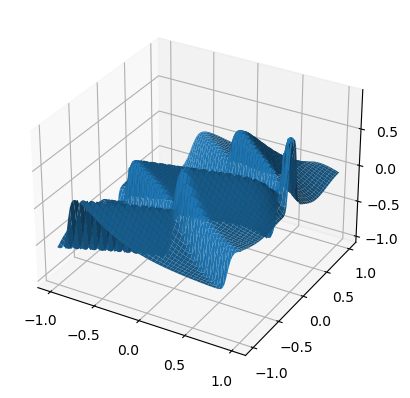

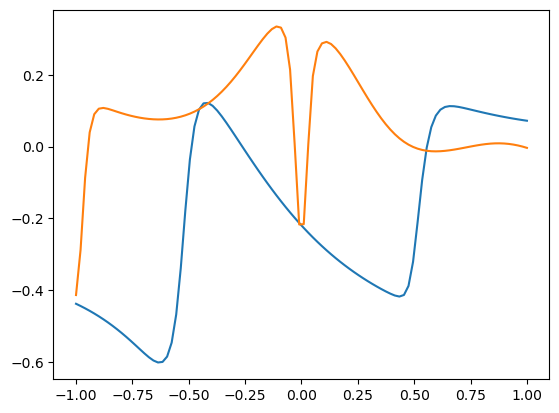

In [151]:
x = np.linspace(-1,1,100)
y = np.linspace(-1,1,100)

xx, yy = np.meshgrid(x, y)
xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

X_star = torch.cat([xx,yy,torch.ones_like(xx)*3],axis = 1)

znn = model(X_star)

xx,yy = np.meshgrid(x, y)

U_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), znn.detach().numpy().flatten(), (xx,yy), method='cubic')

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf=ax.plot_surface(xx,yy,U_pred)
plt.show()

plt.plot(y,U_pred[10,:])
plt.plot(y,U_pred[:,90])


In [18]:
# xy = torch.tensor(dta_set[:int(dta_set.shape[0]/10),:]).float()

dta_set = np.hstack((samples_space(1000,space),samples_param(min_param,max_param,1000).reshape(-1,1)))
xy = torch.tensor(dta_set).float()

In [19]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

x,y, param = Variable(xy[:,0].reshape(-1,1),requires_grad=True),Variable(xy[:,1].reshape(-1,1),requires_grad=True),Variable(xy[:,2].reshape(-1,1),requires_grad=True)

##############################################

f_pred = model.DE(x,y, param)
#############################################

h1.remove()

loss_f = loss(f_pred,torch.zeros_like(f_pred))

df_f_1 = grad(loss_f, f_pred, create_graph=True)[0]

ddf_ff_1 = grad(df_f_1, f_pred, torch.ones_like(df_f_1))[0]

df_theta_1 = torch.cat((forw_activation['layers.activation_3'],torch.ones_like(ddf_ff_1)),1)

print(df_theta_1)

tensor([[-0.2117, -0.9856,  0.6868,  ...,  0.9999,  1.0000,  1.0000],
        [-0.9994, -0.9943,  0.9980,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9999, -0.9966,  0.9998,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-0.6805, -0.9909,  0.9938,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9984, -0.9965,  0.9736,  ...,  0.9999,  1.0000,  1.0000],
        [-0.9999, -0.9568,  1.0000,  ...,  1.0000,  1.0000,  1.0000]])


In [20]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

bc_x_pred = model(torch.cat([torch.zeros_like(x).float()*(-1),y, param], dim=1))

h1.remove()

loss_x_ic = loss(bc_x_pred,torch.zeros_like(x))

df_f_2 = grad(loss_x_ic, bc_x_pred, create_graph=True)[0]

ddf_ff_2 = grad(df_f_2, bc_x_pred, torch.ones_like(df_f_2))[0]

df_theta_2 = torch.cat((forw_activation['layers.activation_3'],torch.ones_like(ddf_ff_2)),1)

print(df_theta_2)

tensor([[-0.4110, -0.9980,  0.8144,  ...,  1.0000,  1.0000,  1.0000],
        [-0.5579, -0.9979,  0.9428,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9153, -0.9967,  0.9994,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-0.8242, -0.9969,  0.9967,  ...,  1.0000,  1.0000,  1.0000],
        [-0.4822, -0.9979,  0.8792,  ...,  1.0000,  1.0000,  1.0000],
        [-0.7144, -0.9976,  0.9864,  ...,  1.0000,  1.0000,  1.0000]])


In [21]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

bc_xx_pred = model(torch.cat([torch.ones_like(x).float(),y, param], dim=1))

h1.remove()

loss_xx_bc = loss(bc_xx_pred,torch.zeros_like(x))

df_f_3 = grad(loss_xx_bc, bc_xx_pred, create_graph=True)[0]

ddf_ff_3 = grad(df_f_3, bc_xx_pred, torch.ones_like(df_f_3))[0]

df_theta_3 = torch.cat((forw_activation['layers.activation_3'],torch.ones_like(ddf_ff_2)),1)

print(df_theta_3)

tensor([[-0.9994, -0.9415,  0.9995,  ...,  0.9998,  1.0000,  1.0000],
        [-0.9998, -0.9456,  0.9999,  ...,  1.0000,  1.0000,  1.0000],
        [-1.0000, -0.9224,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-1.0000, -0.9343,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9996, -0.9433,  0.9998,  ...,  0.9999,  1.0000,  1.0000],
        [-0.9999, -0.9431,  1.0000,  ...,  1.0000,  1.0000,  1.0000]])


In [22]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

bc_y_pred = model(torch.cat([x,torch.zeros_like(y).float()*(-1), param], dim=1))

h1.remove()

loss_y_ic = loss(bc_y_pred,torch.zeros_like(x))

df_f_4 = grad(loss_y_ic, bc_y_pred, create_graph=True)[0]

ddf_ff_4 = grad(df_f_4, bc_y_pred, torch.ones_like(df_f_4))[0]

df_theta_4 = torch.cat((forw_activation['layers.activation_3'],torch.ones_like(ddf_ff_4)),1)

print(df_theta_4)

tensor([[ 0.4682, -0.8448, -0.4591,  ...,  0.9893,  1.0000,  1.0000],
        [-0.9963, -0.9846,  0.7707,  ...,  0.8036,  1.0000,  1.0000],
        [-0.9946, -0.9580,  0.7802,  ...,  0.3283,  1.0000,  1.0000],
        ...,
        [ 0.7119, -0.9756, -0.5087,  ...,  0.9808,  0.9999,  1.0000],
        [-0.9957, -0.9891,  0.5026,  ...,  0.7868,  1.0000,  1.0000],
        [-0.9964, -0.8880,  0.9549,  ...,  0.9176,  1.0000,  1.0000]])


In [ ]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

bc_yy_pred = model(torch.cat([x,torch.zeros_like(y).float()*(-1), param], dim=1))

h1.remove()

loss_yy_bc = loss(bc_yy_pred,torch.zeros_like(x))

df_f_5 = grad(loss_y_ic, bc_y_pred, create_graph=True)[0]

ddf_ff_5 = grad(df_f_5, bc_y_pred, torch.ones_like(df_f_5))[0]

df_theta_5 = torch.cat((forw_activation['layers.activation_3'],torch.ones_like(ddf_ff_5)),1)

print(df_theta_5) 

In [23]:
wt,bias = model.layers[-1].weight, model.layers[-1].bias

param_MAP = torch.cat((wt,bias.reshape(1,1)),1) 

nparam = param_MAP.reshape(-1).shape

print(df_theta_1.shape,df_theta_2.shape,df_theta_3.shape,df_theta_3.shape,nparam)

torch.Size([1000, 41]) torch.Size([1000, 41]) torch.Size([1000, 41]) torch.Size([1000, 41]) torch.Size([41])


In [24]:
H = (xy.shape[0]/2)*(torch.sum(df_theta_1*ddf_ff_1*df_theta_1,axis=0)+ torch.sum(df_theta_2*ddf_ff_2*df_theta_2,axis=0)+\
              torch.sum(df_theta_3*ddf_ff_3*df_theta_3,axis=0)+ torch.sum(df_theta_4*ddf_ff_4*df_theta_4,axis=0)+ torch.sum(df_theta_5*ddf_ff_5*df_theta_5,axis=0))

print(H,H.shape)

tensor([2907.7500, 3697.3870, 2849.7573, 3880.4817, 3808.6514, 3436.3801,
        3999.9961, 2761.2131, 3777.3755, 3091.9570, 3496.5747, 3916.1340,
        3935.4304, 3987.6733, 3705.5442, 3961.0088, 3019.9834, 3949.2312,
        2943.3589, 2974.5786, 3815.2446, 3364.3853, 3341.3928, 3822.8279,
        3272.8169, 3822.5962, 3819.6768, 2343.6199, 3747.6440, 3739.8142,
        3995.8396, 3998.5591, 2705.1536, 3229.1931, 3686.8892, 2643.6172,
        2690.2515, 3542.3088, 3846.9443, 3999.9568, 4000.0005]) torch.Size([41])


In [25]:
from torch.distributions.multivariate_normal import _precision_to_scale_tril


Hfull = (xy.shape[0]/2)*(torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_1, df_theta_1), ddf_ff_1),axis=0) +\
                  torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_2, df_theta_2), ddf_ff_2),axis=0)+\
                    torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_3, df_theta_3), ddf_ff_3),axis=0)+\
                        torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_4, df_theta_4), ddf_ff_4),axis=0)+\
                        torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_5, df_theta_5), ddf_ff_5),axis=0))

print(Hfull,Hfull.shape)

tensor([[ 2907.7498,  2435.2988, -2531.4314,  ..., -2470.1047, -2531.3867,
         -2531.3796],
        [ 2435.2988,  3697.3870, -2640.8545,  ..., -3754.3528, -3836.8892,
         -3836.9094],
        [-2531.4314, -2640.8545,  2849.7573,  ...,  2686.6558,  2740.5288,
          2740.5261],
        ...,
        [-2470.1047, -3754.3528,  2686.6558,  ...,  3846.9443,  3909.7195,
          3909.7393],
        [-2531.3867, -3836.8892,  2740.5288,  ...,  3909.7195,  3999.9565,
          3999.9785],
        [-2531.3796, -3836.9094,  2740.5261,  ...,  3909.7393,  3999.9785,
          4000.0005]]) torch.Size([41, 41])


In [26]:
_sigma_noise=torch.tensor([1])
temperature=torch.tensor([1])

def sigma_noise():
    return _sigma_noise

def _H_factor():
    sigma2 = sigma_noise().square()
    return 1 / sigma2 / temperature

def prior_precision_diag(prior_precision,n_params):
    """Obtain the diagonal prior precision \\(p_0\\) constructed from either
    a scalar, layer-wise, or diagonal prior precision.

    Returns
    -------
    prior_precision_diag : torch.Tensor
    """
    if len(prior_precision) == 1:  # scalar
        return prior_precision * torch.ones(n_params, device=device)

    elif len(prior_precision) == n_params:  # diagonal
        return prior_precision

<Figure size 640x480 with 0 Axes>

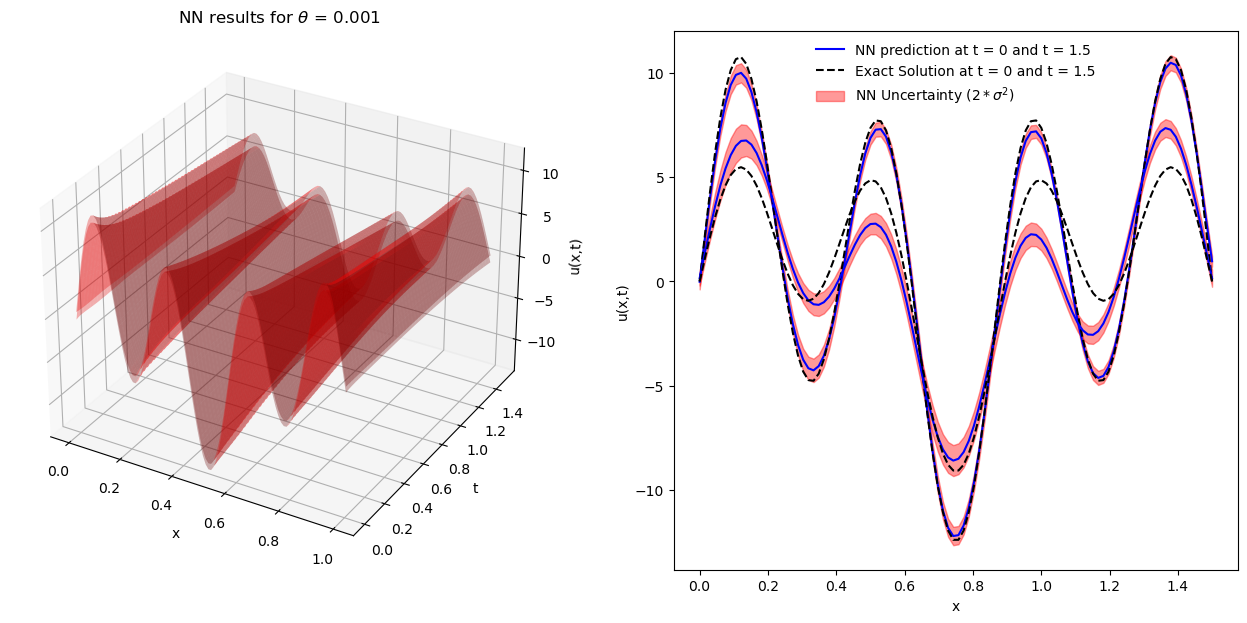

In [27]:
param_trained =  np.array([0.001])
prior_pre=torch.tensor([0.5])
prior_pre_diag = prior_precision_diag(prior_pre,nparam)

x = np.linspace(0,1,100)
y = np.linspace(0,1.5,100)

xx, yy = np.meshgrid(x, y)

# Plotting

plt.suptitle("Full Hessian Approximation",color = "red")

for n,pr in enumerate(param_trained):

    xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

    X_star = torch.cat([xx,yy,torch.ones_like(xx)*pr],axis = 1)
################################################################################################
    forw_activation= {}
    h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

    f = model(X_star)

    h1.remove()

    phi = forw_activation['layers.activation_3']

    bsize = phi.shape[0]
    output_size = f.shape[-1]

    # calculate Jacobians using the feature vector 'phi'
    identity = torch.eye(output_size, device=device).unsqueeze(0).tile(bsize, 1, 1)
    # Jacobians are batch x output x params
    Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
    Js = torch.cat([Js, identity], dim=2)

    post_presicion = _H_factor() * Hfull + torch.diag(prior_pre_diag)


    post_scale = _precision_to_scale_tril(post_presicion)

    post_cov = post_scale @ post_scale.T

    functional_var = torch.einsum('ncp,pq,nkq->nck', Js, post_cov.float(), Js)

    f_mu = f
    f_sigma = functional_var.squeeze().sqrt().cpu().numpy()

################################################################################################
    xx,yy = np.meshgrid(x, y)

    z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.detach().numpy().flatten(), (xx,yy), method='cubic')
    z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')

    z_exact = exact_solution(xx,yy,pr)

    z_error = np.abs(z_pred - z_exact)

    fig = plt.figure(figsize=(16, 7))

    ax = fig.add_subplot(121, projection='3d')
    #axs.plot_surface(xx,yy,z_pred)
    ax.set_title(fr"NN results for $\theta$ = {pr:0.3f}")
    ax.plot_surface(xx,yy,z_pred + 2*z_pred_var,alpha = 0.3, color = "red",label = r"NN Uncertainty ($2*\sigma^{2}$)")
    ax.plot_surface(xx,yy,z_pred - 2*z_pred_var,alpha = 0.3, color = "red")

    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel(r'u(x,t)')


    ax = fig.add_subplot(122)

    ax.plot(y,z_pred[10,:],color = "blue", label = "NN prediction at t = 0 and t = 1.5")
    ax.plot(y,z_exact[10,:],linestyle = "--",color = "black", label = "Exact Solution at t = 0 and t = 1.5")
    ax.fill_between(y, z_pred[10,:]+2*z_pred_var[10,:],z_pred[10,:]-2*z_pred_var[10,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($2*\sigma^{2}$)")

    ax.plot(y,z_pred[-1,:],color = "blue")
    ax.fill_between(y, z_pred[-1,:]+2*z_pred_var[-1,:],z_pred[-1,:]-2*z_pred_var[-1,:],alpha=0.4, color = "red")
    ax.plot(y,z_exact[-1,:],linestyle = "--",color = "black")

    ax.set_xlabel('x')
    ax.set_ylabel(r'u(x,t)')

    plt.legend(frameon = False)

In [28]:
# dta_set = np.load('../Projects-1/Physics _Informed_NN/Models/LA_HeatEq2.npy')
# xy = torch.tensor(dta_set[:int(dta_set.shape[0]/10),:]).float()

dta_set = np.hstack((samples_space(3000,space),samples_param(min_param,max_param,3000).reshape(-1,1)))
xy = torch.tensor(dta_set).float()

In [29]:
nobs = 3000

model2 = DNN(layers)
model2.load_state_dict(torch.load("../Projects-1/Physics _Informed_NN/Models/LA_HeatEq2.pt"))
model2.eval()

DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=3, out_features=40, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=40, out_features=40, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=40, out_features=40, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=40, out_features=1, bias=True)
  )
)

In [30]:
# a dict to store the activations
forw_activation2 = {}
def forw_getActivation2(name):
  # the hook signature
  def hook(model2, input, output):
    forw_activation2[name] = output.detach()
  return hook

h1 = model2.layers[-2].register_forward_hook(forw_getActivation2('layers.activation_3'))

x,y, param = Variable(xy[:,0].reshape(-1,1),requires_grad=True),Variable(xy[:,1].reshape(-1,1),requires_grad=True),Variable(xy[:,2].reshape(-1,1),requires_grad=True)

##############################################

f_pred = model2.DE(x,y, param)
#############################################

h1.remove()

loss_f = loss(f_pred,torch.zeros_like(f_pred))

df_f_1 = grad(loss_f, f_pred, create_graph=True)[0]

ddf_ff_1_2 = grad(df_f_1, f_pred, torch.ones_like(df_f_1))[0]

df_theta_1_2 = torch.cat((forw_activation2['layers.activation_3'],torch.ones_like(ddf_ff_1_2)),1)

print(df_theta_1_2)

tensor([[ 0.9562,  0.4233, -0.9999,  ..., -0.8871, -0.9900,  1.0000],
        [ 0.9994, -0.9948, -1.0000,  ..., -0.9988, -0.9901,  1.0000],
        [ 0.9954, -0.9609, -1.0000,  ..., -0.9993, -0.8655,  1.0000],
        ...,
        [-0.9241, -0.8578, -1.0000,  ..., -0.9880, -0.8511,  1.0000],
        [ 0.7075, -0.9456, -1.0000,  ..., -0.9989, -0.1762,  1.0000],
        [ 0.9687,  0.2911, -0.9999,  ..., -0.9183, -0.9589,  1.0000]])


In [31]:
# a dict to store the activations
forw_activation2 = {}

h1 = model2.layers[-2].register_forward_hook(forw_getActivation2('layers.activation_3'))

bc_x_pred = model2(torch.cat([torch.zeros_like(x).float()*(-1),y, param], dim=1))

h1.remove()

loss_x_ic = loss(bc_x_pred,torch.zeros_like(x))

df_f_2 = grad(loss_x_ic, bc_x_pred, create_graph=True)[0]

ddf_ff_2_2 = grad(df_f_2, bc_x_pred, torch.ones_like(df_f_1))[0]

df_theta_2_2 = torch.cat((forw_activation2['layers.activation_3'],torch.ones_like(ddf_ff_2_2)),1)

print(df_theta_2_2)

tensor([[ 0.9973, -0.2524, -0.0662,  ..., -0.6759, -1.0000,  1.0000],
        [ 0.9994, -0.9932, -0.9914,  ..., -0.9985, -0.9999,  1.0000],
        [ 0.9993, -0.9913, -0.9910,  ..., -0.9978, -0.9998,  1.0000],
        ...,
        [ 0.9908,  0.3881,  0.5785,  ...,  0.1374, -1.0000,  1.0000],
        [ 0.9992, -0.9840, -0.9825,  ..., -0.9959, -0.9999,  1.0000],
        [ 0.9965, -0.3022,  0.0969,  ..., -0.7640, -0.9999,  1.0000]])


In [32]:
# a dict to store the activations
forw_activation2 = {}

h1 = model2.layers[-2].register_forward_hook(forw_getActivation2('layers.activation_3'))

bc_xx_pred = model2(torch.cat([torch.ones_like(x).float(),y, param], dim=1))

h1.remove()

loss_xx_bc = loss(bc_xx_pred,torch.zeros_like(x))

df_f_3 = grad(loss_xx_bc, bc_xx_pred, create_graph=True)[0]

ddf_ff_3_2 = grad(df_f_3, bc_xx_pred, torch.ones_like(df_f_3))[0]

df_theta_3_2 = torch.cat((forw_activation2['layers.activation_3'],torch.ones_like(ddf_ff_3_2)),1)

print(df_theta_3_2)

tensor([[ 0.3352, -0.9996, -1.0000,  ..., -1.0000,  0.9310,  1.0000],
        [ 0.7975, -1.0000, -1.0000,  ..., -1.0000,  0.9042,  1.0000],
        [ 0.8428, -1.0000, -1.0000,  ..., -1.0000,  0.9319,  1.0000],
        ...,
        [ 0.2086, -0.9991, -1.0000,  ..., -0.9999,  0.9206,  1.0000],
        [ 0.8194, -1.0000, -1.0000,  ..., -1.0000,  0.9317,  1.0000],
        [ 0.2767, -0.9996, -1.0000,  ..., -1.0000,  0.9505,  1.0000]])


In [33]:
# a dict to store the activations
forw_activation2 = {}

h1 = model2.layers[-2].register_forward_hook(forw_getActivation2('layers.activation_3'))

ic_pred = model2(torch.cat([x,torch.zeros_like(x).float(), param], dim=1))

h1.remove()

loss_u_ic = loss(ic_pred,(4*torch.sin(3*torch.pi*x)+ 9*torch.sin(7*torch.pi*x)))

df_f_4 = grad(loss_u_ic, ic_pred, create_graph=True)[0]

ddf_ff_4_2 = grad(df_f_4, ic_pred, torch.ones_like(df_f_4))[0]

df_theta_4_2 = torch.cat((forw_activation2['layers.activation_3'],torch.ones_like(ddf_ff_4_2)),1)

print(df_theta_4_2)

                bc_y_pred,bc_yy_pred = pinn(torch.cat([x,torch.zeros_like(y).float()*(-1), param], dim=1)), pinn(torch.cat([x,torch.zeros_like(y).float()*(-1), param], dim=1))

                , = ,
                loss_y_ic,loss_yy_bc = loss(bc_y_pred,torch.zeros_like(x)),loss(bc_yy_pred,torch.zeros_like(x))

tensor([[ 0.9295,  0.7451, -0.9998,  ..., -0.6852, -0.9906,  1.0000],
        [ 0.9932, -0.1273, -0.9763,  ..., -0.2843, -0.9977,  1.0000],
        [ 0.9260,  0.7529, -0.9998,  ..., -0.6516, -0.9914,  1.0000],
        ...,
        [-0.9703, -0.6608, -1.0000,  ..., -0.9729, -0.9714,  1.0000],
        [-0.4864,  0.5937, -1.0000,  ..., -0.7542, -0.8959,  1.0000],
        [ 0.9589,  0.4240, -0.9998,  ..., -0.8652, -0.9444,  1.0000]])


In [34]:
wt,bias = model2.layers[-1].weight, model2.layers[-1].bias

param_MAP_2 = torch.cat((wt,bias.reshape(1,1)),1) 

nparam2 = param_MAP_2.reshape(-1).shape

print(df_theta_1_2.shape,df_theta_2_2.shape,df_theta_3_2.shape,df_theta_3_2.shape,nparam2)

torch.Size([3000, 41]) torch.Size([3000, 41]) torch.Size([3000, 41]) torch.Size([3000, 41]) torch.Size([41])


In [35]:
H2 = (xy.shape[0]/2)*(torch.sum(df_theta_1_2*ddf_ff_1_2*df_theta_1_2,axis=0)+ torch.sum(df_theta_2_2*ddf_ff_2_2*df_theta_2_2,axis=0)+\
              torch.sum(df_theta_3_2*ddf_ff_3_2*df_theta_3_2,axis=0)+ torch.sum(df_theta_4_2*ddf_ff_4_2*df_theta_4_2,axis=0))

print(H2,H2.shape)

tensor([ 8876.1113,  8832.7969, 10712.2451, 11967.3262, 11736.7949,  8344.6045,
         9740.4561, 11713.3145, 11997.6074,  7851.9067, 11372.2656, 10612.8223,
        11998.3330, 10234.1211,  9412.2803, 10724.7246, 11437.6484,  6276.9150,
         6737.5283, 10394.4062,  9875.4561,  9533.0332, 10979.0303, 10623.4170,
        10508.7549,  9869.5342, 10703.5410,  8943.9688, 11723.7715, 11998.3691,
        11426.1611,  9964.4697,  8101.4819,  9132.7441,  8977.3408,  8107.0557,
         8590.9248,  3616.5586,  9866.2783,  9637.1602, 12000.0000]) torch.Size([41])


In [36]:
Hfull2 = (xy.shape[0]/2)*(torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_1_2, df_theta_1_2), ddf_ff_1_2),axis=0) +\
                  torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_2_2, df_theta_2_2), ddf_ff_2_2),axis=0)+\
                    torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_3_2, df_theta_3_2), ddf_ff_3_2),axis=0)+\
                        torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_4_2, df_theta_4_2), ddf_ff_4_2),axis=0))

print(Hfull2,Hfull2.shape)

tensor([[  8876.1113,  -5007.0303,  -6620.1270,  ...,  -6487.5098,
          -3559.3721,   7959.2998],
        [ -5007.0303,   8832.7969,   7725.3315,  ...,   8222.1387,
           -220.5349,  -7631.8438],
        [ -6620.1270,   7725.3315,  10712.2451,  ...,   9485.2627,
           2575.5288, -10653.2275],
        ...,
        [ -6487.5098,   8222.1387,   9485.2627,  ...,   9866.2773,
           2183.3105, -10221.9912],
        [ -3559.3721,   -220.5349,   2575.5288,  ...,   2183.3105,
           9637.1602,  -3922.1829],
        [  7959.2998,  -7631.8438, -10653.2275,  ..., -10221.9912,
          -3922.1829,  12000.0000]]) torch.Size([41, 41])


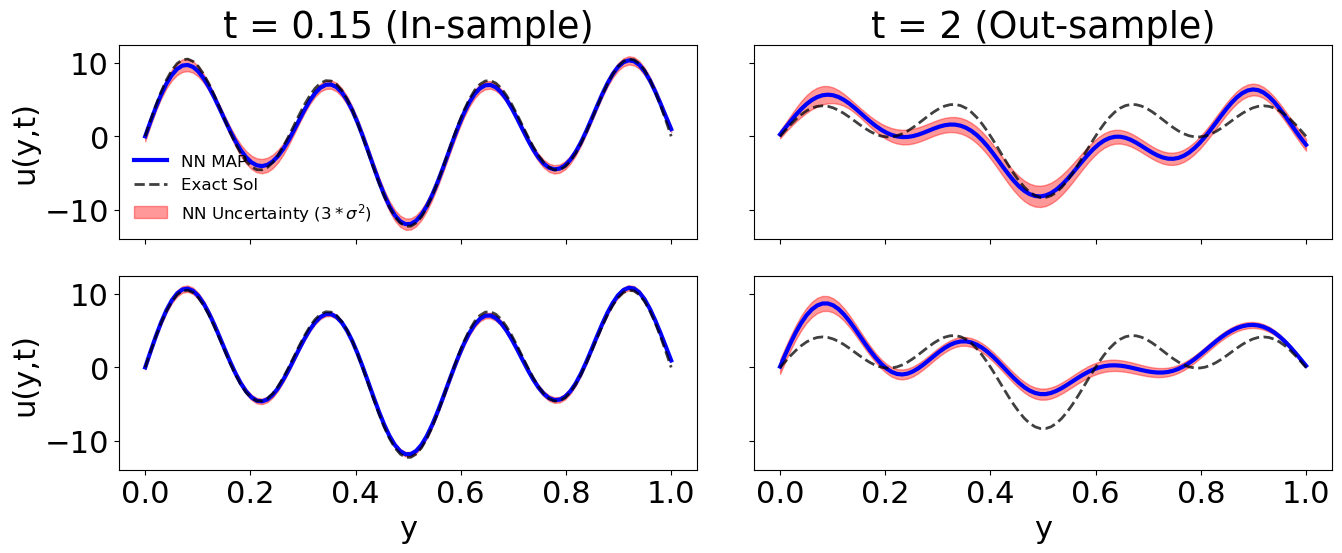

In [40]:
param_trained =  np.array([0.001])
prior_pre=torch.tensor([0.01])
prior_pre_diag = prior_precision_diag(prior_pre,nparam)

x = np.linspace(0,1,100)
y = np.linspace(0,2,100)

xx, yy = np.meshgrid(x, y)

# Plotting

#plt.suptitle("Full Hessian Approximation",color = "red")
#fig = plt.figure(figsize=(15, 6))

for n,pr in enumerate(param_trained):

    xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

    X_star = torch.cat([xx,yy,torch.ones_like(xx)*pr],axis = 1)

    forw_activation= {}
    h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

    f = model(X_star)

    h1.remove()

    phi = forw_activation['layers.activation_3']

    bsize = phi.shape[0]
    output_size = f.shape[-1]

    # calculate Jacobians using the feature vector 'phi'
    identity = torch.eye(output_size, device=device).unsqueeze(0).tile(bsize, 1, 1)
    # Jacobians are batch x output x params
    Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
    Js = torch.cat([Js, identity], dim=2)

    post_presicion = _H_factor() * Hfull + torch.diag(prior_pre_diag)


    post_scale = _precision_to_scale_tril(post_presicion)

    post_cov = post_scale @ post_scale.T

    functional_var = torch.einsum('ncp,pq,nkq->nck', Js, post_cov.float(), Js)

    f_mu = f
    f_sigma = functional_var.squeeze().sqrt().cpu().numpy()

################################################################################################
    xx,yy = np.meshgrid(x, y)

    z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.detach().numpy().flatten(), (xx,yy), method='cubic')
    z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')

    z_exact = exact_solution(xx,yy,pr)

    z_error = np.abs(z_pred - z_exact)


    #ax = fig.add_subplot(221, projection='3d')
    #axs.plot_surface(xx,yy,z_pred)
    # ax.set_title(fr"NN trained with K-samples = 1,000",color = "red")
    # ax.plot_surface(xx,yy,z_pred + 2*z_pred_var,alpha = 0.3, color = "red",label = r"NN Uncertainty ($2*\sigma^{2}$)")
    # ax.plot_surface(xx,yy,z_pred - 2*z_pred_var,alpha = 0.3, color = "red")

    # ax.set_xlabel('x')
    # ax.set_ylabel('t')
        # ax.set_zlabel(r'u(x,t)')
    fig, axs = plt.subplots(2, 2, figsize=(14, 6), sharey=True,sharex=True)
    plt.rcParams.update({'font.size': 22})

    #ax = plt.subplot(221)
    axs[0,0].set_title(fr"t = 0.15 (In-sample)",color = "black")
    axs[0,0].plot(x,z_pred[10,:],color = "blue", label = "NN MAP",linewidth=3)
    axs[0,0].plot(x,z_exact[10,:],linestyle = "--",alpha = 0.75,color = "black", label = "Exact Sol",linewidth=2)
    axs[0,0].fill_between(x, z_pred[10,:]+3*z_pred_var[10,:],z_pred[10,:]-3*z_pred_var[10,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($3*\sigma^{2})$")

    #ax.set_xlabel('x')
    axs[0,0].set_ylabel(r'u(y,t)')

    axs[0,0].legend(frameon = False, prop={'size': 12})

    #axs[1] = plt.subplot(222,sharey = ax)
    axs[0,1].set_title(fr"t = 2 (Out-sample)",color = "black")
    axs[0,1].plot(x,z_pred[-1,:],color = "blue",linewidth=3)
    axs[0,1].plot(x,z_exact[-1,:],linestyle = "--",alpha = 0.75,color = "black",linewidth=2)
    axs[0,1].fill_between(x, z_pred[-1,:]+3*z_pred_var[-1,:],z_pred[-1,:]-3*z_pred_var[-1,:],alpha=0.4, color = "red")


    #ax1.set_xlabel('x')
    #axs[0,1].set_ylabel(r'u(x,t)')
################################################################################################
    forw_activation2= {}
    h1 = model2.layers[-2].register_forward_hook(forw_getActivation2('layers.activation_3'))

    f = model2(X_star)

    h1.remove()

    phi = forw_activation2['layers.activation_3']

    bsize = phi.shape[0]
    output_size = f.shape[-1]

    # calculate Jacobians using the feature vector 'phi'
    identity = torch.eye(output_size, device=device).unsqueeze(0).tile(bsize, 1, 1)
    # Jacobians are batch x output x params
    Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
    Js = torch.cat([Js, identity], dim=2)

    post_presicion = _H_factor() * Hfull2 + torch.diag(prior_pre_diag)


    post_scale = _precision_to_scale_tril(post_presicion)

    post_cov = post_scale @ post_scale.T

    functional_var = torch.einsum('ncp,pq,nkq->nck', Js, post_cov.float(), Js)

    f_mu = f
    f_sigma = functional_var.squeeze().sqrt().cpu().numpy()
################################################################################################
    xx,yy = np.meshgrid(x, y)

    z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.detach().numpy().flatten(), (xx,yy), method='cubic')
    z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')

    z_exact = exact_solution(xx,yy,pr)

    z_error = np.abs(z_pred - z_exact)

    #ax = fig.add_subplot(223, projection='3d')
    #axs.plot_surface(xx,yy,z_pred)
    # ax.set_title(fr"NN trained with K-samples = 3,000",color = "blue")
    # ax.plot_surface(xx,yy,z_pred + 2*z_pred_var,alpha = 0.3, color = "blue")
    # ax.plot_surface(xx,yy,z_pred - 2*z_pred_var,alpha = 0.3, color = "blue")

    # ax.set_xlabel('x')
    # ax.set_ylabel('t')
    # ax.set_zlabel(r'u(x,t)')

    axs[1,0].plot(x,z_pred[10,:],color = "blue",linewidth=3)
    axs[1,0].plot(x,z_exact[10,:],linestyle = "--",alpha = 0.75,color = "black",linewidth=2)
    axs[1,0].fill_between(x, z_pred[10,:]+3*z_pred_var[10,:],z_pred[10,:]-3*z_pred_var[10,:],alpha=0.4, color = "red")

    axs[1,0].set_xlabel('y')
    axs[1,0].set_ylabel(r'u(y,t)')

    axs[1,1].plot(x,z_pred[-1,:],color = "blue",linewidth=3)
    axs[1,1].plot(x,z_exact[-1,:],linestyle = "--",alpha = 0.75,color = "black",linewidth=2)
    axs[1,1].fill_between(x, z_pred[-1,:]+3*z_pred_var[-1,:],z_pred[-1,:]-3*z_pred_var[-1,:],alpha=0.4, color = "red")

    axs[1,1].set_xlabel('y')
    #axs[1,1].set_ylabel(r'u(x,t)')

plt.tight_layout()
plt.savefig("Results_FullHessian.pdf")

<Figure size 640x480 with 0 Axes>

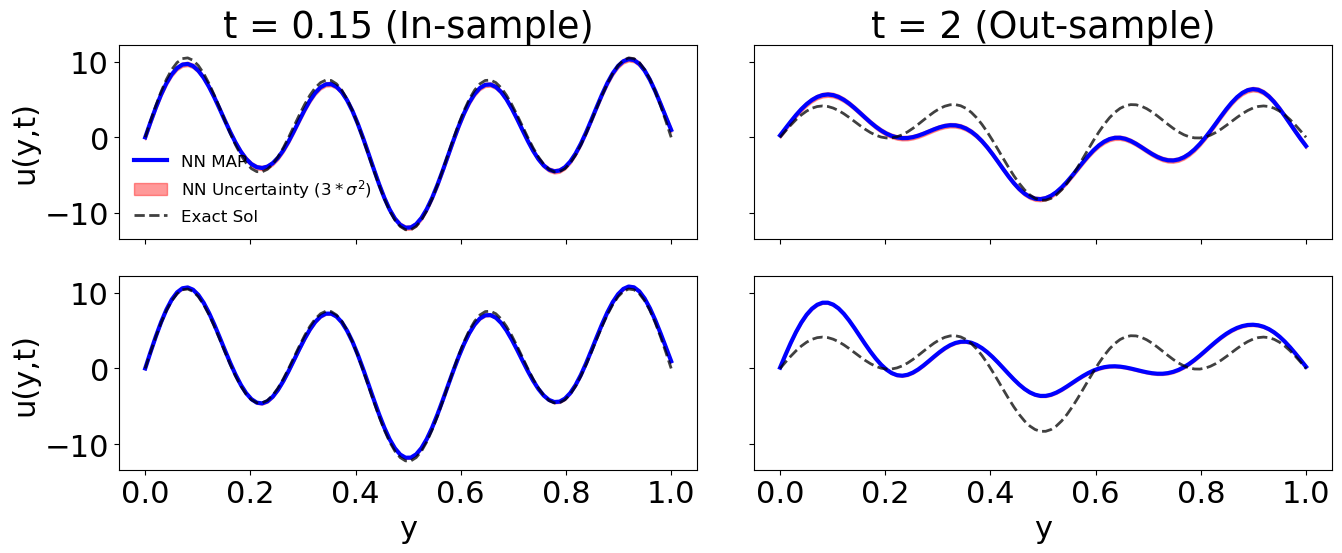

In [38]:
param_trained =  np.array([0.001])
prior_pre=torch.tensor([0.001])
prior_pre_diag = prior_precision_diag(prior_pre,nparam)

x = np.linspace(0,1,100)
y = np.linspace(0,2,100)

xx, yy = np.meshgrid(x, y)

# Plotting

plt.suptitle("Full Hessian Approximation",color = "red")

for n,pr in enumerate(param_trained):

    xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

    X_star = torch.cat([xx,yy,torch.ones_like(xx)*pr],axis = 1)

    forw_activation= {}
    h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

    f = model(X_star)

    h1.remove()

    phi = forw_activation['layers.activation_3']

    bsize = phi.shape[0]
    output_size = f.shape[-1]

    # calculate Jacobians using the feature vector 'phi'
    identity = torch.eye(output_size, device=device).unsqueeze(0).tile(bsize, 1, 1)
    # Jacobians are batch x output x params
    Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
    Js = torch.cat([Js, identity], dim=2)

    post_presicion = _H_factor() * H + prior_pre_diag


    post_variance = 1 / post_presicion

    functional_var = torch.einsum('ncp,p,nkp->nck', Js, post_variance.float(), Js)

    f_mu = f
    f_sigma = functional_var.squeeze().sqrt().cpu().numpy()

################################################################################################
    xx,yy = np.meshgrid(x, y)

    z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.detach().numpy().flatten(), (xx,yy), method='cubic')
    z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')

    z_exact = exact_solution(xx,yy,pr)

    z_error = np.abs(z_pred - z_exact)

    fig, axs = plt.subplots(2, 2, figsize=(14, 6), sharey=True,sharex=True)
    plt.rcParams.update({'font.size': 22})

    #ax = plt.subplot(221)
    axs[0,0].set_title(fr"t = 0.15 (In-sample)",color = "black")
    axs[0,0].plot(x,z_pred[10,:],color = "blue", label = "NN MAP",linewidth=3)
    axs[0,0].fill_between(x, z_pred[10,:]+3*z_pred_var[10,:],z_pred[10,:]-3*z_pred_var[10,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($3*\sigma^{2})$")
    axs[0,0].plot(x,z_exact[10,:],linestyle = "--",alpha = 0.75,color = "black", label = "Exact Sol",linewidth=2)
    #ax.set_xlabel('x')
    axs[0,0].set_ylabel(r'u(y,t)')

    axs[0,0].legend(frameon = False, prop={'size': 12})

    #axs[1] = plt.subplot(222,sharey = ax)
    axs[0,1].set_title(fr"t = 2 (Out-sample)",color = "black")
    axs[0,1].plot(x,z_pred[-1,:],color = "blue",linewidth=3)
    axs[0,1].fill_between(x, z_pred[-1,:]+3*z_pred_var[-1,:],z_pred[-1,:]-3*z_pred_var[-1,:],alpha=0.4, color = "red")
    axs[0,1].plot(x,z_exact[-1,:],linestyle = "--",alpha = 0.75,color = "black",linewidth=2)

################################################################################################
    forw_activation2= {}
    h1 = model2.layers[-2].register_forward_hook(forw_getActivation2('layers.activation_3'))

    f = model2(X_star)

    h1.remove()

    phi = forw_activation2['layers.activation_3']

    bsize = phi.shape[0]
    output_size = f.shape[-1]

    # calculate Jacobians using the feature vector 'phi'
    identity = torch.eye(output_size, device=device).unsqueeze(0).tile(bsize, 1, 1)
    # Jacobians are batch x output x params
    Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
    Js = torch.cat([Js, identity], dim=2)

    post_presicion = _H_factor() * H2 + prior_pre_diag


    post_variance = 1 / post_presicion

    functional_var = torch.einsum('ncp,p,nkp->nck', Js, post_variance.float(), Js)

    f_mu = f
    f_sigma = functional_var.squeeze().sqrt().cpu().numpy()

################################################################################################
    xx,yy = np.meshgrid(x, y)

    z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.detach().numpy().flatten(), (xx,yy), method='cubic')
    z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')

    z_exact = exact_solution(xx,yy,pr)

    z_error = np.abs(z_pred - z_exact)

    #ax = fig.add_subplot(223, projection='3d')
    #axs.plot_surface(xx,yy,z_pred)
    # ax.set_title(fr"NN trained with K-samples = 3,000",color = "blue")
    # ax.plot_surface(xx,yy,z_pred + 2*z_pred_var,alpha = 0.3, color = "blue")
    # ax.plot_surface(xx,yy,z_pred - 2*z_pred_var,alpha = 0.3, color = "blue")

    # ax.set_xlabel('x')
    # ax.set_ylabel('t')
    # ax.set_zlabel(r'u(x,t)')


    axs[1,0].plot(x,z_pred[10,:],color = "blue",linewidth=3)
    axs[1,0].fill_between(x, z_pred[10,:]+3*z_pred_var[10,:],z_pred[10,:]-3*z_pred_var[10,:],alpha=0.4, color = "red")
    axs[1,0].plot(x,z_exact[10,:],linestyle = "--",alpha = 0.75,color = "black",linewidth=2)
    axs[1,0].set_xlabel('y')
    axs[1,0].set_ylabel(r'u(y,t)')

    axs[1,1].plot(x,z_pred[-1,:],color = "blue",linewidth=3)
    axs[1,1].fill_between(x, z_pred[-1,:]+3*z_pred_var[-1,:],z_pred[-1,:]-3*z_pred_var[-1,:],alpha=0.4, color = "red")
    axs[1,1].plot(x,z_exact[-1,:],linestyle = "--",alpha = 0.75,color = "black",linewidth=2)
    axs[1,1].set_xlabel('y')
    #axs[1,1].set_ylabel(r'u(x,t)')
plt.tight_layout()

plt.savefig("Results_DiagonalHessian.pdf")